In [156]:
import numpy as np
import pandas as pd
from icecream import ic
from matplotlib import pyplot as plt
from sklearn.model_selection import (
    cross_val_score,
    GridSearchCV,
    train_test_split,
)
from sklearn.preprocessing import OneHotEncoder, StandardScaler, TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    root_mean_squared_error,
)

from xgboost import XGBRegressor

import datetime

# DATA 607 - Machine Learning

## Class 7 &mdash; 2025.05.14 &mdash; Feature engineering

In [170]:
df = pd.read_parquet("data/rossmann_train.parquet")
df

,Store,DayOfWeek,Date,Sales,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263.0,True,0,True
1,2,5,2015-07-31,6064.0,True,0,True
2,3,5,2015-07-31,8314.0,True,0,True
3,4,5,2015-07-31,13995.0,True,0,True
4,5,5,2015-07-31,4822.0,True,0,True
...,...,...,...,...,...,...,...
844333,682,2,2013-01-01,3375.0,False,1,True
844334,733,2,2013-01-01,10765.0,False,1,True
844335,769,2,2013-01-01,5035.0,False,1,True
844336,948,2,2013-01-01,4491.0,False,1,True


In [171]:
cutoff = pd.to_datetime(datetime.date(2015, 1, 1))
train_mask = df["Date"] < cutoff
val_mask = df["Date"] >= cutoff

df_train = df[train_mask]
df_val = df[val_mask]

y_train = df_train["Sales"]
y_val = df_val["Sales"]

ic(df_train.shape, df_val.shape)

ic| df_train.shape: (648309, 7), df_val.shape: (196029, 7)


((648309, 7), (196029, 7))

### Trivial estimators

In [172]:
# Mean and median estimator

mean_mape = mean_absolute_percentage_error(y_val, np.full_like(y_val, y_train.mean()))

median_mape = mean_absolute_percentage_error(
    y_val, np.full_like(y_val, y_train.median())
)

# Error down 10% just from switching mean to median!
ic(mean_mape, median_mape)
pass

ic

| mean_mape: 0.3684062445636179, median_mape: 0.33452303700354363


### Relative error versus logarithmic error

$$
\begin{aligned}
\log\hat{y} - \log y &= \log\frac{\hat{y}}{y}\\
&\approx \frac{\hat{y}}{y} - 1\\
&= \frac{\hat{y} - y}{y}
\end{aligned}
$$

- Instead of using a relative metric, just take the logarithm of $y$.

In [173]:
df["logSales"] = np.log(df["Sales"])
df_train = df[train_mask]
df_val = df[val_mask]
y_train = df_train["logSales"]
y_val = df_val["logSales"]

mean_mae = mean_absolute_error(y_val, np.full_like(y_val, y_train.mean()))
median_mae = mean_absolute_error(y_val, np.full_like(y_val, y_train.median()))

ic(mean_mae, median_mae)
pass

ic| mean_mae: 0.32089022402497575, median_mae: 0.32080861850002756


- Taking the log also fixes the discrepancy between the mean and the median.

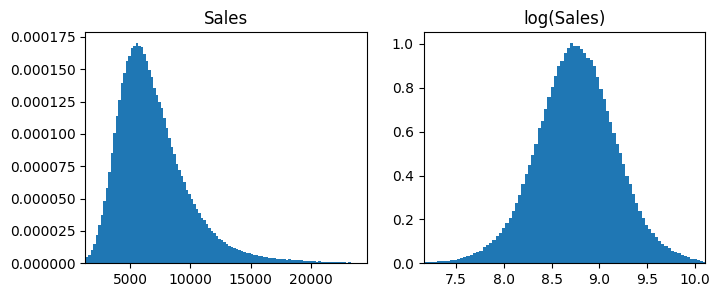

In [174]:
fig, (a0, a1) = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
a0.hist(df["Sales"], density=True, bins=200)
a0.set_xlim(np.quantile(df["Sales"], [0.001, 0.999]))
a0.set_title("Sales")
a1.hist(df["logSales"], density=True, bins=200)
a1.set_xlim(np.quantile(df["logSales"], [0.001, 0.999]))
a1.set_title("log(Sales)")
plt.show()

### Target encoding

#### Group by promo

In [175]:
means = df_train.groupby("Promo")["logSales"].agg("mean")
preds = df_val["Promo"].map(means)
mean_absolute_error(y_val, preds)

0.2899295528908407

#### Group by store

In [176]:
means = df_train.groupby("Store")["logSales"].mean()
preds = df_val["Store"].map(means)
mean_absolute_error(y_val, preds)

0.21196930895649843

### Pandas can do linear regression!

In [ ]:
store_encoder = OneHotEncoder()
store_train = store_encoder.fit_transform(df_train[["Store"]])
model = LinearRegression(fit_intercept=False)
model.fit(store_train, y_train)
assert np.allclose(model.coef_, df_train.groupby("Store")["logSales"].mean())

#### Target encoding

In [178]:
features = ["Store", "DayOfWeek", "Promo", "StateHoliday", "SchoolHoliday"]

X_te = pd.DataFrame()
for feature in features:
    means = df_train.groupby(feature)["logSales"].mean()
    X_te[feature] = df[feature].map(means)
X_te_train = X_te[train_mask]
X_te_val = X_te[val_mask]

X_te_train

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday
196029,8.459317,8.728051,8.59652,8.749906,8.777272
196030,8.449609,8.728051,8.59652,8.749906,8.777272
196031,8.795101,8.728051,8.59652,8.749906,8.777272
196032,9.147825,8.728051,8.59652,8.749906,8.777272
196033,8.368869,8.728051,8.59652,8.749906,8.777272
...,...,...,...,...,...
844333,9.269316,8.772672,8.59652,8.807584,8.777272
844334,9.597358,8.772672,8.59652,8.807584,8.777272
844335,9.239538,8.772672,8.59652,8.807584,8.777272
844336,8.765829,8.772672,8.59652,8.807584,8.777272


In [179]:
model = LinearRegression()
model.fit(X_te_train, y_train)
mean_absolute_error(y_val, model.predict(X_te_val))

0.15372028835715643

In [180]:
model = XGBRegressor(learning_rate=1.0)
model.fit(X_te_train, y_train)
mean_absolute_error(y_val, model.predict(X_te_val))

0.13824812130288056

#### Interaction: Group by store and promo

In [181]:
means = df_train.groupby(["Store", "Promo"])["logSales"].mean()
preds = df_val.join(means, on=["Store", "Promo"], how="left", lsuffix="blah")[
    "logSales"
]
mean_absolute_error(y_val, preds)

0.15344372151963612

In [ ]:
store_promo_df = pd.DataFrame(
    {"store_promo": df["Store"].astype(str) + "-" + df["Promo"].astype(int).astype(str)}
)
store_promo_encoder = OneHotEncoder()
store_promo_train = store_promo_encoder.fit_transform(store_promo_df[train_mask])
store_promo_val = store_promo_encoder.transform(store_promo_df[val_mask])

model = LinearRegression(fit_intercept=False)
model.fit(store_promo_train, y_train)

means = df_train.groupby(["Store", "Promo"])["logSales"].agg("mean")
preds = df_val.join(means, on=["Store", "Promo"], how="left", lsuffix="blah")[
    "logSales"
]
assert np.allclose(model.predict(store_promo_val), preds)

In [186]:
encoder = OneHotEncoder(drop="first")
X_train = encoder.fit_transform(df_train[features])
X_val = encoder.transform(df_val[features])

In [187]:
model = LinearRegression()
model.fit(X_train, y_train)
mean_absolute_error(y_val, model.predict(X_val))

0.15116130514903017

In [188]:
model = XGBRegressor(learning_rate=0.9, max_depth=25)
model.fit(X_train, y_train)
mean_absolute_error(y_val, model.predict(X_val))

0.11448768506108059

In [189]:
store_df = pd.read_csv("~/.kaggle/data/rossmann-store-sales/store.csv").set_index(
    "Store"
)
store_df

,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
Store,,,,,,,,,
1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN


In [204]:
joined_df = df.join(store_df["CompetitionDistance"], on="Store", how="left")
joined_df

,Store,DayOfWeek,Date,Sales,Promo,StateHoliday,SchoolHoliday,logSales,CompetitionDistance
0,1,5,2015-07-31,5263.0,True,0,True,8.568456,1270.0
1,2,5,2015-07-31,6064.0,True,0,True,8.710125,570.0
2,3,5,2015-07-31,8314.0,True,0,True,9.025696,14130.0
3,4,5,2015-07-31,13995.0,True,0,True,9.546455,620.0
4,5,5,2015-07-31,4822.0,True,0,True,8.480944,29910.0
...,...,...,...,...,...,...,...,...,...
844333,682,2,2013-01-01,3375.0,False,1,True,8.124151,150.0
844334,733,2,2013-01-01,10765.0,False,1,True,9.284055,860.0
844335,769,2,2013-01-01,5035.0,False,1,True,8.524169,840.0
844336,948,2,2013-01-01,4491.0,False,1,True,8.409831,1430.0


In [206]:
categorical_features = [
    "Store",
    "DayOfWeek",
    "Promo",
    "StateHoliday",
    "SchoolHoliday",
]
column_transformer = ColumnTransformer(
    transformers=[
        (
            "categorical",
            OneHotEncoder(drop="first"),
            categorical_features,
        ),
        ("numerical", "passthrough", ["CompetitionDistance"]),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)

In [213]:
X_train = column_transformer.fit_transform(joined_df.loc[train_mask, :])
X_val = column_transformer.transform(joined_df.loc[val_mask, :])

In [216]:
model = LinearRegression()
model.fit(X_train, y_train)
mean_absolute_error(y_val, model.predict(X_val))

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values